# Phys 600: HW 4
Yarone Tokayer

October 29, 2023

In [1]:
# Install packages

#from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

import numpy as np
from scipy.special import zeta

import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

# Problem 1

## 1.2: Figure for $X_e(z)$

In [3]:
# Constants

Tcmb0 = 0.235 * u.meV # CMB temperature today
eta = 6e-10 # Baryons-to-photon fraction (Baumann)
E_I = 13.6 * u.eV # Ionization energy of hydrogen 
m_e = 0.510998950 * u.MeV # Mass of electron (Wikipedia)

In [23]:
def x_e(z):
    '''
    Function to compute the electron fraction as a function of redshift

    Inputs:
    z - Redshift

    Returns:
    x_e - free electron fraction at that redshift
    '''

    T = Tcmb0 * ( 1 + z )

    a = (2 * zeta(3) / np.pi ** 2) * eta * ((2 * np.pi * T / m_e) ** (3/2)) * np.exp(E_I / T)

    x_e = ((-1 + np.sqrt(1 + 4*a)) / (2 * a)).to(u.dimensionless_unscaled).value

    return x_e

## 1.3: Invert to find $z(X_e)$

In [40]:
def x_e_to_z(x_e_target, tolerance=1e-6):
    '''
    Function to find redshift (z) given the free electron fraction (x_e) using a bisection method.

    Inputs:
    x_e_target - Free electron fraction
    tolerance - Tolerance for the bisection method convergence

    Returns:
    z - Redshift corresponding to the given lookback time
    '''

    # Initialize the search interval for z
    z_low, z_high = 1e2, 1e4

    # Perform the bisection search
    while z_high - z_low > tolerance:
        z_mid = (z_low + z_high) / 2
        x_e_mid = x_e(z_mid)
        if x_e_mid > x_e_target:
            z_high = z_mid
        else:
            z_low = z_mid

    # The bisection method has converged; return the redshift
    return z_mid

Our two points of interest:

In [45]:
x_e_to_z(0.1), x_e_to_z(0.5)

(1258.9799694891553, 1377.2434625017922)

Now we can plot everything:

In [38]:
# Redshift range to calculate

z = np.linspace(1000, 2000, 1000)

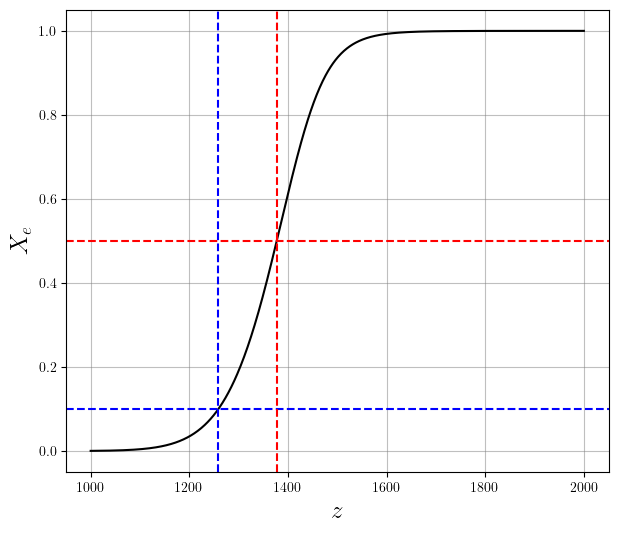

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

ax.plot(z, x_e(z), color='black')
ax.axhline(y=0.5, color='red', ls='--')
ax.axhline(y=0.1, color='blue', ls='--')
ax.axvline(x=x_e_to_z(0.5), color='red', ls='--')
ax.axvline(x=x_e_to_z(0.1), color='blue', ls='--')

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', alpha=0.5, linestyle='-')
ax.yaxis.grid(color='gray', alpha=0.5, linestyle='-')

ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel(r'$ X_e$', fontsize=18)

# ax.legend(fontsize=14)

fig.savefig('/Users/yaronetokayer/Yale Drive/Classes/PHYS 600/phys600 hw/phys600 hw 4/x_e_plot.png',
           dpi=300, bbox_inches='tight')

## 1.4: Age of the universe

In [47]:
h_0 = 70 * u.km / u.s / u.Mpc

In [58]:
((1 / h_0) * (2/3) * (1 / (1 + x_e_to_z(0.1)))**(3/2)).to(u.kyr)

<Quantity 208.21490618 kyr>

## 1.5: $z$ at decoupling

Evaluate the target value for $X_e(z)(1+z)^{3/2}$ (see write-up)

In [86]:
# Constants
Om0 = 0.3; sigma_T = 2e-3 * u.MeV**-2

In [83]:
# Need to convert h_0 to natural units
h_0_nat = h_0 * u.GeV * 6.5821e-25 * u.s

In [84]:
target = (h_0_nat * np.pi**2 * np.sqrt(Om0) / (2 * eta * zeta(3) * sigma_T * Tcmb0**3)).to(u.dimensionless_unscaled)
target

<Quantity 215.59192399>

Use a bisection method to solve for $z$:

In [85]:
tolerance=1e-6

# Initialize the search interval for z
z_low, z_high = 1e2, 1e4

# Perform the bisection search
while z_high - z_low > tolerance:
    z_dec = (z_low + z_high) / 2
    x_e_mid = x_e(z_dec) * (1 + z_dec)**(3/2)
    if x_e_mid > target:
        z_high = z_dec
    else:
        z_low = z_dec

# The bisection method has converged; return the redshift
z_dec

1113.8222924259026

The age of the universe at this redshift:

In [87]:
((1 / h_0) * (2/3) * (1 / (1 + z_dec))**(3/2)).to(u.kyr)

<Quantity 250.17782492 kyr>

The free electron fraction at this redshift:

In [88]:
x_e(z_dec)

0.005791939562935705

### Density Parameters
Check our work for $\Omega_\mathrm{x}(z)$ using Astropy

In [6]:
z = 0.5

cosmo.Om(z), cosmo.Ode(z)

(0.5912408759124087, 0.4087591240875912)

Agrees!

### Luminosity and Angular Diameter Distances

In [7]:
res = 100 # Resolution of plot
z_axis = np.linspace(0, 10, res)

d_l = np.zeros(len(z_axis))
d_a = np.zeros(len(z_axis))

d_l_eds = np.zeros(len(z_axis))
d_a_eds = np.zeros(len(z_axis))

In [8]:
# Calculate d_l and d_a for the default cosmology

for i in range(res):
    z = z_axis[i]
    Ode0 = 0.7

    # Calculate comoving distance from z=0 to z
    z_array = np.linspace(0, z, 1000)
    integrand = 1 / ( np.sqrt(Om0 * (1 + z_array)**3 + Ode0) )
    d_m = np.trapz(integrand, x=z_array)

    # Convert to d_l and d_a
    d_l[i] = (1 + z) * d_m
    d_a[i] = d_m / (1 + z)

In [9]:
# Calculate d_l and d_a for a matter only universe (EdS)

for i in range(res):
    z = z_axis[i]

    # Calculate comoving distance from z=0 to z
    z_array = np.linspace(0, z, 1000)
    integrand = 1 / ( np.sqrt((1 + z_array)**3) ) # Om0=1, Omde0=0
    d_m = np.trapz(integrand, x=z_array)

    # Convert to d_l and d_a
    d_l_eds[i] = (1 + z) * d_m
    d_a_eds[i] = d_m / (1 + z)

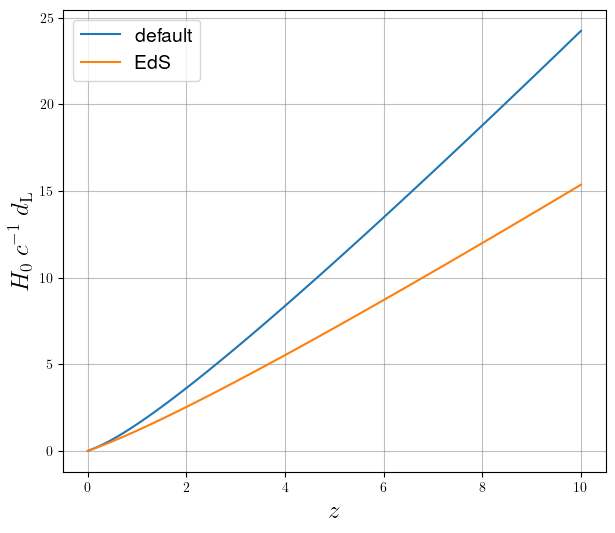

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

ax.plot(z_axis, d_l, label='default')
ax.plot(z_axis, d_l_eds, label='EdS')

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', alpha=0.5, linestyle='-')
ax.yaxis.grid(color='gray', alpha=0.5, linestyle='-')

ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel(r'$ H_0\ c^{-1}\ d_\mathrm{L}$', fontsize=18)

ax.legend(fontsize=14)

fig.savefig('/Users/yaronetokayer/Yale Drive/Classes/PHYS 600/phys600 hw/phys600 hw 3/d_l_plot.png',
           dpi=300, bbox_inches='tight')

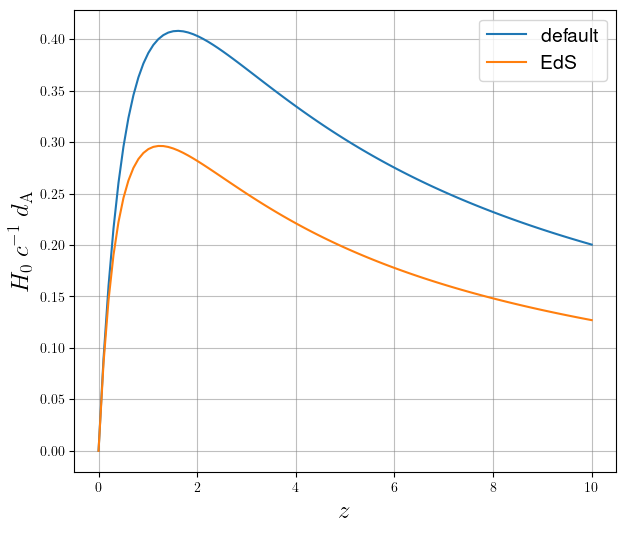

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

ax.plot(z_axis, d_a, label='default')
ax.plot(z_axis, d_a_eds, label='EdS')

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', alpha=0.5, linestyle='-')
ax.yaxis.grid(color='gray', alpha=0.5, linestyle='-')

ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel(r'$ H_0\ c^{-1}\ d_\mathrm{A}$', fontsize=18)

ax.legend(fontsize=14)

fig.savefig('/Users/yaronetokayer/Yale Drive/Classes/PHYS 600/phys600 hw/phys600 hw 3/d_a_plot.png',
           dpi=300, bbox_inches='tight')

### Looking Back

In [12]:
def t_l(z, h, Om0, Ode0):
    '''
    Function to compute the lookback time as a function of z

    Inputs:
    z - redshift
    h - H0/(100 km/s/Mpc)
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0

    Returns:
    t_l - lookback time in years
    '''

    H0 = h * 100 * u.km / u.s / u.Mpc

    z_array = np.linspace(0, z, 1000)

    integrand = 1 / H0 / ( 1 + z_array ) / np.sqrt(Om0 * ( 1 + z_array )**3 + Ode0)
    return np.trapz(integrand, x=z_array).to(u.year)

In [13]:
def t_l_to_z(t_l_target, h, Om0, Ode0, tolerance=1e-6):
    '''
    Function to find redshift (z) given the lookback time (t_l) using a bisection method.

    Inputs:
    t_l_target - Lookback time (astropy units expected)
    h - H0/(100 km/s/Mpc)
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0
    tolerance - Tolerance for the bisection method convergence

    Returns:
    z - Redshift corresponding to the given lookback time
    '''

    # Initialize the search interval for z
    z_low, z_high = 0.0, 1e3

    # Perform the bisection search
    while z_high - z_low > tolerance:
        z_mid = (z_low + z_high) / 2
        t_mid = t_l(z_mid, h, Om0, Ode0)
        if t_mid > t_l_target:
            z_high = z_mid
        else:
            z_low = z_mid

    # The bisection method has converged; return the redshift
    return z_mid

In [14]:
# Compute z for t_l = 1e10 years

h = 0.7
Om0 = 0.3
Ode0 = 0.7
t_l_target = 1e10 * u.year

t_l_to_z(t_l_target, h, Om0, Ode0)

1.8555903807282448

Check our work for $t_\mathrm{t}$ using Astropy

In [15]:
z=1.8555903807282448
cosmo.lookback_time(z)

<Quantity 9.99999559 Gyr>

We are correct to 3 significant figures, as required.

## Problem 3

To what redshift is our expansion accurate to 10%?  To answer this, we create two functions: one that computes the exact numerical integral $\chi(z)$, and another that computes the series expansion to third order.  Then we use a bisection method to find the $z$ at which the expansion differs by 10%.  We also define a function to compute the second order approximation.

### Define functions

In [16]:
def chi(z, Om0, Ode0):
    '''
    Function to compute the dimensionless comoving distance as a function of z

    Inputs:
    z - redshift
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0

    Returns:
    chi - dimensionless comoving distance (H_0 \chi * c^-1)
    '''

    z_array = np.linspace(0, z, 1000)

    integrand = 1 / np.sqrt( Om0 * ( 1 + z_array )**3 + Ode0 + (1 - Om0 - Ode0) * ( 1 + z_array )**2 )
    return np.trapz(integrand, x=z_array)

In [22]:
def chi_thirdorder(z, Om0, Ode0):
    '''
    Function to compute the approximate dimensionless comoving distance to third order in z 
    as a function of z

    Inputs:
    z - redshift
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0

    Returns:
    chi - dimensionless comoving distance (H_0 \chi * c^-1)
    '''

    z_array = np.linspace(0, z, 1000)

    integrand = (
        1 
        + ( ( -2 + 2*Ode0 - Om0 ) / 2 ) * z_array 
        + ( ( 8 - 20*Ode0 + 12*Ode0**2 + 4*Om0 + 3*Om0**2 - 12*Ode0*Om0 ) / 8 ) * z_array**2 
    )
    
    return np.trapz(integrand, x=z_array)

def chi_secondorder(z, Om0, Ode0):
    '''
    Function to compute the approximate dimensionless comoving distance to third order in z 
    as a function of z

    Inputs:
    z - redshift
    Om0 - Fractional matter density at z=0
    Ode0 - Fractional dark energy density at z=0

    Returns:
    chi - dimensionless comoving distance (H_0 \chi * c^-1)
    '''

    z_array = np.linspace(0, z, 1000)

    integrand = (
        1 
        + ( ( -2 + 2*Ode0 - Om0 ) / 2 ) * z_array 
    )
    
    return np.trapz(integrand, x=z_array)

### Find the $z$ at which the error exceed 10%

For the third order approximation:

In [18]:
# Initialize the search interval for z
z_low, z_high = 0.0, 2

tolerance = 1e-6 # Precision of z
target = 0.1 # Looking for delta to be within 10%

# Perform the bisection search
while z_high - z_low > tolerance:
    z_mid = (z_low + z_high) / 2
    delta_mid = np.abs(( chi_thirdorder(z_mid, Om0, Ode0) - chi(z_mid, Om0, Ode0) ) / chi(z_mid, Om0, Ode0)) # % pct error
    if delta_mid > target:
        z_high = z_mid
    else:
        z_low = z_mid

z_mid

1.2042932510375977

For the second order approximation:

In [63]:
# Initialize the search interval for z
z_low, z_high = 0.0, 2.5

tolerance = 1e-6 # Precision of z
target = 0.1 # Looking for delta to be within 10%

# Perform the bisection search
while z_high - z_low > tolerance:
    z_mid = (z_low + z_high) / 2
    delta_mid = np.abs(( chi_secondorder(z_mid, Om0, Ode0) - chi(z_mid, Om0, Ode0) ) / chi(z_mid, Om0, Ode0)) # fractinal error
    if delta_mid > target:
        z_high = z_mid
    else:
        z_low = z_mid

z_mid

2.0541709661483765

For the first oder approximation:

This will help us see at what redshift we begin to probe the cosmological density parameters.

In [59]:
# Initialize the search interval for z
z_low, z_high = 0.0, 2

tolerance = 1e-6 # Precision of z
target = 0.1 # Looking for delta to be within 10%

# Perform the bisection search
while z_high - z_low > tolerance:
    z_mid = (z_low + z_high) / 2
    delta_mid = np.abs(( z_mid - chi(z_mid, Om0, Ode0) ) / chi(z_mid, Om0, Ode0)) # % pct error
    if delta_mid > target:
        z_high = z_mid
    else:
        z_low = z_mid

z_mid

0.3857755661010742

Surprisingly, we find that the third order approximation diverges at a smaller redshift than the second order approximation.  Let's plot each term of the expansion relative to the exact value

In [61]:
z = np.linspace(0,1,1000)
exact = chi(z, Om0, Ode0)
third = chi_thirdorder(z, Om0, Ode0)
second = chi_secondorder(z, Om0, Ode0)
first = z

error2 = second - exact
error3 = third - exact

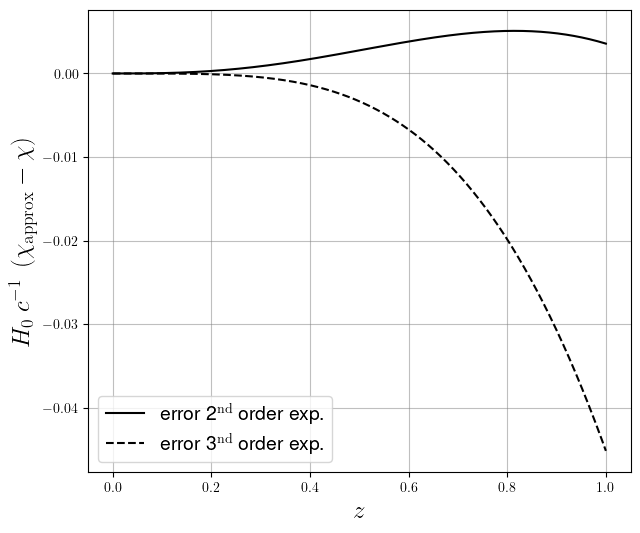

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

# ax.plot(z, exact, ls='-', color='black', label='exact')
# ax.plot(z, first, ls='--', color='black', label='one term exp.')
# ax.plot(z, second, ls=':', color='black', label='two term exp.')
# ax.plot(z, third, ls='-.', color='black', label='three term exp.')

ax.plot(z, error2, ls='-', color='black', label='error 2$^\mathrm{nd}$ order exp.')
ax.plot(z, error3, ls='--', color='black', label='error 3$^\mathrm{nd}$ order exp.')

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', alpha=0.5, linestyle='-')
ax.yaxis.grid(color='gray', alpha=0.5, linestyle='-')

ax.set_xlabel('$z$', fontsize=18)
ax.set_ylabel(r'$ H_0\ c^{-1}\ \left(\chi_\mathrm{approx} - \chi\right)$', fontsize=18)

ax.legend(fontsize=14)

fig.savefig('/Users/yaronetokayer/Yale Drive/Classes/PHYS 600/phys600 hw/phys600 hw 3/chi_plot.png',
           dpi=300, bbox_inches='tight')